In [16]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
demographic = pd.read_csv('raw_data/demographic.csv', encoding='ISO-8859-1')
diet = pd.read_csv('raw_data/diet.csv', encoding='ISO-8859-1')
examination = pd.read_csv('raw_data/examination.csv', encoding='ISO-8859-1')
labs = pd.read_csv('raw_data/labs.csv', encoding='ISO-8859-1')
medication = pd.read_csv('raw_data/medications.csv', encoding='ISO-8859-1')
questionnaire = pd.read_csv('raw_data/questionnaire.csv', encoding='ISO-8859-1')

In [3]:
nutrition_variables = pd.DataFrame({
    'Variable': ['DR1TCARB', 'DR1TKCAL', 'DR1TPROT', 'DR1TTFAT'],
    'Description': ['Carbohydrate (G)','Energy (KCAL)', 'Protein (G)', 'Fat (G)'],
    'Category': ['Dietary Nutrition', 'Dietary Nutrition', 'Dietary Nutrition', 'Dietary Nutrition'],
    'Data Type': ['Continuous', 'Continuous', 'Continuous', 'Continuous'],
    'Notes': ['Total carbohydrate intake', 'Total energy intake', 'Total protein intake', 'Total fat intake']
})

variables = pd.read_csv('variables.csv')
variables = pd.concat([variables, nutrition_variables], ignore_index=True).drop_duplicates(subset='Variable', keep='last')
variables_lst = variables['Variable'].tolist()

In [4]:
# print all variables in varaibles_lst that are in none of the dataframes
for var in variables_lst:
    if var not in demographic.columns and var not in diet.columns and var not in examination.columns and var not in labs.columns and var not in medication.columns and var not in questionnaire.columns:
        print(var)

In [5]:
# select columns in each dataset that are in the variables list (may not in it), join then by SEQN in each dataset

demographic_subset = demographic[["SEQN"]+list(set(variables_lst).intersection(demographic.columns))]
diet_subset = diet[["SEQN"]+list(set(variables_lst).intersection(diet.columns))]
examination_subset = examination[["SEQN"]+list(set(variables_lst).intersection(examination.columns))]
labs_subset = labs[["SEQN"]+list(set(variables_lst).intersection(labs.columns))]
medication_subset = medication[["SEQN"]+list(set(variables_lst).intersection(medication.columns))]
questionnaire_subset = questionnaire[["SEQN"]+list(set(variables_lst).intersection(questionnaire.columns))]
# merge all datasets
merged_df = demographic_subset.merge(diet_subset, on='SEQN').merge(examination_subset, on='SEQN').merge(labs_subset, on='SEQN').merge(medication_subset, on='SEQN').merge(questionnaire_subset, on='SEQN').drop_duplicates()
merged_df

,SEQN,WTMEC2YR,DMDEDUC2,DMDHHSIZ,RIDAGEYR,RIAGENDR,RIDRETH3,RIDEXPRG,INDFMPIR,DMDMARTL,...,ALQ110,BPQ080,PAQ715,SMQ040,DIQ010,SLD010H,SXQ294,SMQ020,BPQ020,OHQ845
0,73557,13481.042095,3.0,3,69,1,4,NaN,0.84,4.0,...,NaN,1.0,8.0,3.0,1.0,7.0,NaN,1.0,1.0,1.0
2,73558,24471.769625,3.0,4,54,1,3,NaN,1.78,1.0,...,NaN,1.0,8.0,2.0,1.0,9.0,NaN,1.0,1.0,4.0
6,73559,57193.285376,4.0,2,72,1,3,NaN,4.51,1.0,...,NaN,1.0,0.0,3.0,1.0,8.0,NaN,1.0,1.0,3.0
11,73560,55766.512438,NaN,4,9,1,3,NaN,2.52,NaN,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0
12,73561,65541.871229,5.0,2,73,2,3,NaN,5.00,1.0,...,NaN,2.0,1.0,NaN,2.0,9.0,NaN,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19575,83727,28115.568221,5.0,5,26,1,2,NaN,NaN,5.0,...,NaN,2.0,1.0,NaN,2.0,7.0,NaN,2.0,2.0,4.0
19576,83728,16512.138781,NaN,4,2,2,1,NaN,1.95,NaN,...,NaN,NaN,0.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0
19577,83729,26902.344381,5.0,1,42,2,4,2.0,3.66,3.0,...,NaN,2.0,1.0,NaN,2.0,7.0,NaN,2.0,2.0,2.0
19578,83730,26686.025573,NaN,4,7,1,2,NaN,1.05,NaN,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0


In [6]:
# replace all categorical variables with the categroies value in the Notes column in the variables.csv
# for example: DMDEDUC2,  Education Level (Adults 20+),Demographics,Categorical,"Less than 9th grade, 9–11th grade, High school/GED, Some college/AA degree, College graduate or above"
# then 1 is "Less than 9th grade", 2 is "9–11th grade" and so on
# categorical variables
categorical_variables = variables[variables['Data Type'] == 'Categorical']
for i in range(1, len(merged_df.columns)):
    if merged_df.columns[i] in categorical_variables['Variable'].tolist():
        categories = categorical_variables[categorical_variables['Variable'] == merged_df.columns[i]]['Notes'].values[0].split(', ')
        # convert any value out of range to be NaN
        merged_df[merged_df.columns[i]] = merged_df[merged_df.columns[i]].apply(
            lambda x: categories[int(x)-1] if not pd.isnull(x) and int(x) <= len(categories) else np.nan
        )

# replace column names each column names' corresponding Description
merged_df.columns = ["Respondent"] + variables.set_index('Variable').loc[merged_df.columns[1:]]['Description'].tolist()  
merged_df

,Respondent,Full Sample 2-Year MEC Exam Weight,Education Level (Adults 20+),Household Size,Age of the Participant (years),Gender of the Participant,Race/Ethnicity,Pregnancy Status at Examination,Family Poverty Income Ratio,Marital Status,...,Ever Had at Least 12 Alcoholic Drinks in One Year,Now Taking Hypertension Medication,Frequency of Muscle-Strengthening Activities per Week,Current Smoking Frequency,Doctor Told You Have Diabetes,Sleep Duration (hours),Ever Told Had Chlamydia,Smoked at Least 100 Cigarettes in Life,Ever Told Had High Blood Pressure,Time Since Last Dental Visit
0,73557,13481.042095,High school/GED,3,69,Male,Non-Hispanic Black,NaN,0.84,Separated,...,NaN,Yes,8.0,Not at all,Yes,7.0,NaN,Yes,Yes,<6 months
2,73558,24471.769625,High school/GED,4,54,Male,Non-Hispanic White,NaN,1.78,Married,...,NaN,Yes,8.0,Some days,Yes,9.0,NaN,Yes,Yes,Never
6,73559,57193.285376,Some college/AA degree,2,72,Male,Non-Hispanic White,NaN,4.51,Married,...,NaN,Yes,0.0,Not at all,Yes,8.0,NaN,Yes,Yes,>1 year
11,73560,55766.512438,NaN,4,9,Male,Non-Hispanic White,NaN,2.52,NaN,...,NaN,NaN,2.0,NaN,No,NaN,NaN,NaN,NaN,6–12 months
12,73561,65541.871229,College graduate or above,2,73,Female,Non-Hispanic White,NaN,5.00,Married,...,NaN,No,1.0,NaN,No,9.0,NaN,No,Yes,6–12 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19575,83727,28115.568221,College graduate or above,5,26,Male,Other Hispanic,NaN,NaN,Never married,...,NaN,No,1.0,NaN,No,7.0,NaN,No,No,Never
19576,83728,16512.138781,NaN,4,2,Female,Mexican American,NaN,1.95,NaN,...,NaN,NaN,0.0,NaN,No,NaN,NaN,NaN,NaN,>1 year
19577,83729,26902.344381,College graduate or above,1,42,Female,Non-Hispanic Black,Not pregnant,3.66,Divorced,...,NaN,No,1.0,NaN,No,7.0,NaN,No,No,6–12 months
19578,83730,26686.025573,NaN,4,7,Male,Other Hispanic,NaN,1.05,NaN,...,NaN,NaN,2.0,NaN,No,NaN,NaN,NaN,NaN,>1 year


In [7]:
# check any col have nan > 50%
nan_count = merged_df.isna().sum()
nan_count = nan_count[nan_count > 0]
nan_count = nan_count/merged_df.shape[0]
nan_count = nan_count[nan_count > 0.5]
nan_count

Pregnancy Status at Examination                      0.876185
Urine Creatinine (mg/dL)                             0.725874
Calculated LDL Cholesterol (mg/dL)                   0.683583
Urinary Albumin (mg/L)                               0.729542
Triglycerides (mg/dL)                                0.679405
Number of Prescription Medications Taken             0.595435
Ever Told Had Genital Herpes                         0.824009
Ever Had at Least 12 Alcoholic Drinks in One Year    0.834200
Current Smoking Frequency                            0.746255
Ever Told Had Chlamydia                              0.823703
dtype: float64

In [8]:
df = merged_df
df["Obesity"] = (df['Body Mass Index (BMI)'] >= 30).astype(int)
df["Hypertension"] = ((df['Systolic Blood Pressure (mmHg)'] >= 130) | 
                      (df['Diastolic Blood Pressure (mmHg)'] >= 80) | 
                      (df['Ever Told Had High Blood Pressure'] == 'Yes') | 
                      (df['Now Taking Hypertension Medication'] == 'Yes')).astype(int)
df["Diabetes"] = ((df['Glycohemoglobin (A1C) %'] >= 6.5) | 
                  (df['Doctor Told You Have Diabetes'] == 'Yes')).astype(int)
df["High Cholesterol"] = ((df['Total Cholesterol (mg/dL)'] >= 240) | 
                          (df['Calculated LDL Cholesterol (mg/dL)'] >= 160) | 
                          (df['Triglycerides (mg/dL)'] >= 200) | 
                          (df['Now Taking Hypertension Medication'] == 'Yes')).astype(int)

# drop NAs in dietary nutrition columns 
df = df.dropna(subset=nutrition_variables["Description"])
df.to_csv('processed_data.csv', index=False)
df

,Respondent,Full Sample 2-Year MEC Exam Weight,Education Level (Adults 20+),Household Size,Age of the Participant (years),Gender of the Participant,Race/Ethnicity,Pregnancy Status at Examination,Family Poverty Income Ratio,Marital Status,...,Doctor Told You Have Diabetes,Sleep Duration (hours),Ever Told Had Chlamydia,Smoked at Least 100 Cigarettes in Life,Ever Told Had High Blood Pressure,Time Since Last Dental Visit,Obesity,Hypertension,Diabetes,High Cholesterol
0,73557,13481.042095,High school/GED,3,69,Male,Non-Hispanic Black,NaN,0.84,Separated,...,Yes,7.0,NaN,Yes,Yes,<6 months,0,1,1,1
2,73558,24471.769625,High school/GED,4,54,Male,Non-Hispanic White,NaN,1.78,Married,...,Yes,9.0,NaN,Yes,Yes,Never,0,1,1,1
6,73559,57193.285376,Some college/AA degree,2,72,Male,Non-Hispanic White,NaN,4.51,Married,...,Yes,8.0,NaN,Yes,Yes,>1 year,0,1,1,1
11,73560,55766.512438,NaN,4,9,Male,Non-Hispanic White,NaN,2.52,NaN,...,No,NaN,NaN,NaN,NaN,6–12 months,0,0,0,0
12,73561,65541.871229,College graduate or above,2,73,Female,Non-Hispanic White,NaN,5.00,Married,...,No,9.0,NaN,No,Yes,6–12 months,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19568,83724,29383.486541,High school/GED,2,80,Male,Non-Hispanic White,NaN,3.09,Married,...,No,9.0,NaN,Yes,Yes,<6 months,0,1,0,1
19575,83727,28115.568221,College graduate or above,5,26,Male,Other Hispanic,NaN,NaN,Never married,...,No,7.0,NaN,No,No,Never,0,0,0,0
19576,83728,16512.138781,NaN,4,2,Female,Mexican American,NaN,1.95,NaN,...,No,NaN,NaN,NaN,NaN,>1 year,0,0,0,0
19577,83729,26902.344381,College graduate or above,1,42,Female,Non-Hispanic Black,Not pregnant,3.66,Divorced,...,No,7.0,NaN,No,No,6–12 months,1,1,0,0


In [ ]:
# get list of lifestyle variables health outcomes, demographics 
lifestyle_factors = list(set(merged_df.columns).intersection(variables[variables['Category'] == 'Lifestyle Factors']['Description'].tolist()))
print(lifestyle_factors)
health_outcomes = list(set(merged_df.columns).intersection(variables[variables['Category'] == 'Health Outcomes']['Description'].tolist()))
print(health_outcomes)
demographics = list(set(merged_df.columns).intersection(variables[variables['Category'] == 'Demographics']['Description'].tolist()))
print(demographics)
dietary_nutrition = list(set(merged_df.columns).intersection(variables[variables['Category'] == 'Dietary Nutrition']['Description'].tolist()))
print(dietary_nutrition)

In [ ]:
# print the top N variables in each lifestyle_factors, health_outcomes, demographics with least missing values
N = 5

percent_missing_lifestyle_factors = {}
for var in lifestyle_factors:
    percent_missing_lifestyle_factors[var] = merged_df[var].isna().sum()/merged_df.shape[0]
percent_missing_lifestyle_factors = dict(sorted(percent_missing_lifestyle_factors.items(), key=lambda item: item[1]))
print(list(percent_missing_lifestyle_factors.keys())[:N])

percent_missing_health_outcomes = {}
for var in health_outcomes:
    percent_missing_health_outcomes[var] = merged_df[var].isna().sum()/merged_df.shape[0]
percent_missing_health_outcomes = dict(sorted(percent_missing_health_outcomes.items(), key=lambda item: item[1]))
print(list(percent_missing_health_outcomes.keys())[:N])

percent_missing_demographics = {}
for var in demographics:
    percent_missing_demographics[var] = merged_df[var].isna().sum()/merged_df.shape[0]
percent_missing_demographics = dict(sorted(percent_missing_demographics.items(), key=lambda item: item[1]))
print(list(percent_missing_demographics.keys())[:N])

percent_missing_dietary_nutrition = {}
for var in dietary_nutrition:
    percent_missing_dietary_nutrition[var] = merged_df[var].isna().sum()/merged_df.shape[0]
percent_missing_dietary_nutrition = dict(sorted(percent_missing_dietary_nutrition.items(), key=lambda item: item[1]))
print(list(percent_missing_dietary_nutrition.keys())[:N])

### EDA

In [9]:
nutritional_columns = ['Carbohydrate (G)', 'Energy (KCAL)', 'Protein (G)', 'Fat (G)']
diseases = ['Obesity', 'Hypertension', 'Diabetes', 'High Cholesterol']

# Checking if the columns exist in the dataset
available_columns = [col for col in nutritional_columns + diseases if col in df.columns]

# Subset the data for these columns
df_subset = df[available_columns]

# Display descriptive statistics and check for missing values
descriptive_stats = df_subset.describe()

descriptive_stats

,Carbohydrate (G),Energy (KCAL),Protein (G),Fat (G),Obesity,Hypertension,Diabetes,High Cholesterol
count,8531.000000,8531.000000,8531.000000,8531.00000,8531.000000,8531.000000,8531.000000,8531.000000
mean,242.737141,1964.538624,74.536708,75.09880,0.251202,0.389403,0.091080,0.262103
std,123.956800,984.493064,44.723181,45.50421,0.433730,0.487644,0.287739,0.439804
min,8.670000,117.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,158.720000,1309.500000,45.780000,43.71500,0.000000,0.000000,0.000000,0.000000
50%,223.300000,1794.000000,66.050000,66.23000,0.000000,0.000000,0.000000,0.000000
75%,301.165000,2430.000000,93.860000,94.99000,1.000000,1.000000,0.000000,1.000000
max,1423.870000,12108.000000,869.490000,548.38000,1.000000,1.000000,1.000000,1.000000


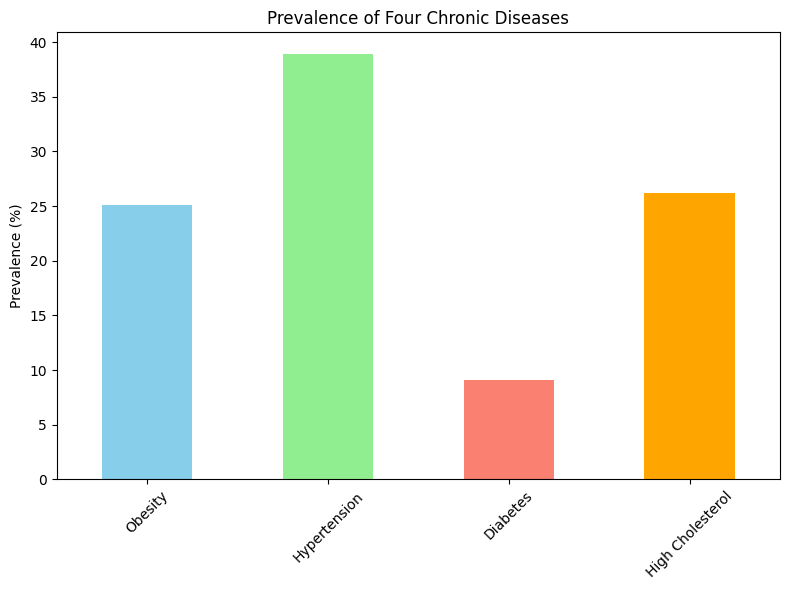

In [12]:
# Let's create a bar chart and pie chart for the distribution/proportion of the 4 diseases

# Calculate the proportions of each disease
disease_proportions = df_subset[diseases].mean() * 100

# Bar chart for the distribution of the 4 diseases
fig, ax = plt.subplots(figsize=(8, 6))
disease_proportions.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
ax.set_title('Prevalence of Four Chronic Diseases')
ax.set_ylabel('Prevalence (%)')
ax.set_xticklabels(['Obesity', 'Hypertension', 'Diabetes', 'High Cholesterol'], rotation=45)

plt.tight_layout()
plt.show()


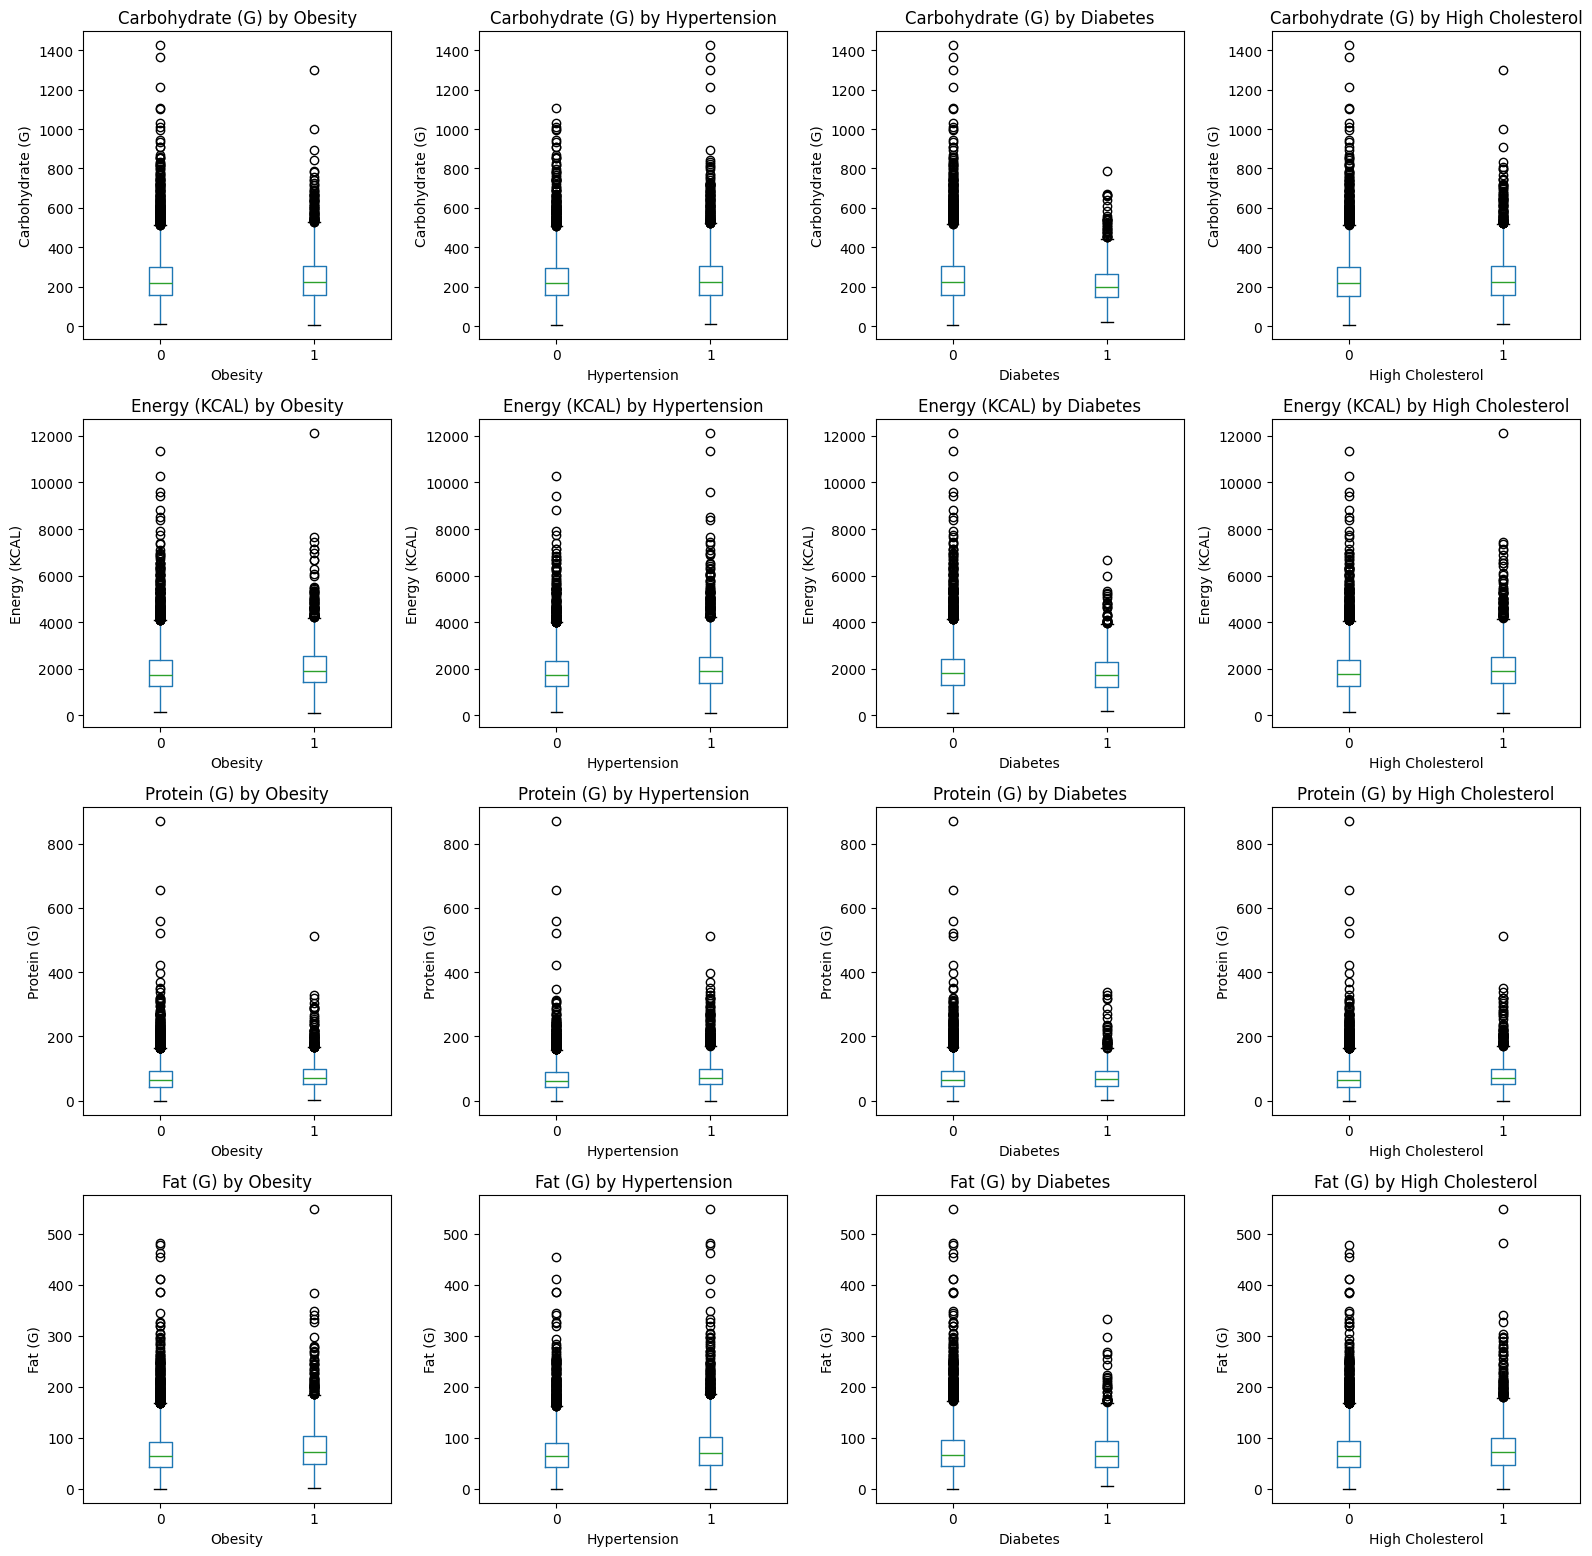

In [15]:
# Create a 4x4 grid of boxplots: 4 rows for dietary factors and 4 columns for chronic diseases
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Loop through each dietary factor and health outcome to create the grouped boxplots
for i, nutrition in enumerate(nutritional_columns):
    for j, disease in enumerate(diseases):
        # Create a boxplot grouped by disease status
        df_subset.boxplot(column=nutrition, by=disease, ax=axes[i, j], grid=False)

        axes[i, j].set_title(f'{nutrition} by {disease}')
        axes[i, j].set_xlabel(f'{disease}')
        axes[i, j].set_ylabel(f'{nutrition}')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.suptitle('')  # Remove the automatic title
plt.show()
